In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import gymnasium as gym
import tensorflow as tf
from tensorflow.keras import layers, Model, optimizers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --------------------------
# Helper function: Metrics plot
# --------------------------
def plot_metrics(total_rewards, actor_losses, critic_losses, window_1=10, window_2=25):
    """
    Plots the raw metrics and their rolling statistics over windows of window_1 and window_2 episodes.
    Each column corresponds to one metric:
      - Column 1: Total Reward
      - Column 2: Actor Loss
      - Column 3: Critic Loss
    Row 1: Raw metrics.
    Row 2: Rolling mean, median, and std over a window of window_1 episodes.
    Row 3: Rolling mean, median, and std over a window of window_2 episodes.
    """
    def plot_rolling(ax, data, window, label):
        series = pd.Series(data)
        rolling_mean = series.rolling(window=window, min_periods=1).mean()
        rolling_median = series.rolling(window=window, min_periods=1).median()
        rolling_std = series.rolling(window=window, min_periods=1).std()
        ax.plot(episodes, rolling_mean, label="Mean")
        ax.plot(episodes, rolling_median, label="Median")
        ax.fill_between(episodes, rolling_mean - rolling_std, rolling_mean + rolling_std,
                        alpha=0.2, label="Std")
        ax.set_title(f"Rolling (window={window}) {label}")
        ax.set_xlabel("Episode")
        ax.legend()

    episodes = range(1, len(total_rewards) + 1)
    fig, axs = plt.subplots(3, 3, figsize=(18, 12))
    
    axs[0, 0].plot(episodes, total_rewards, label="Raw")
    axs[0, 0].set_title("Raw Total Reward")
    axs[0, 0].set_xlabel("Episode")
    axs[0, 0].set_ylabel("Total Reward")
    axs[0, 0].legend()
    
    axs[0, 1].plot(episodes, actor_losses, label="Raw", color="tab:orange")
    axs[0, 1].set_title("Raw Actor Loss")
    axs[0, 1].set_xlabel("Episode")
    axs[0, 1].set_ylabel("Actor Loss")
    axs[0, 1].legend()
    
    axs[0, 2].plot(episodes, critic_losses, label="Raw", color="tab:green")
    axs[0, 2].set_title("Raw Critic Loss")
    axs[0, 2].set_xlabel("Episode")
    axs[0, 2].set_ylabel("Critic Loss")
    axs[0, 2].legend()
    
    plot_rolling(axs[1, 0], total_rewards, window_1, "Total Reward")
    plot_rolling(axs[1, 1], actor_losses, window_1, "Actor Loss")
    plot_rolling(axs[1, 2], critic_losses, window_1, "Critic Loss")
    
    plot_rolling(axs[2, 0], total_rewards, window_2, "Total Reward")
    plot_rolling(axs[2, 1], actor_losses, window_2, "Actor Loss")
    plot_rolling(axs[2, 2], critic_losses, window_2, "Critic Loss")
    
    plt.tight_layout()
    plt.show()

# --------------------------
# Helper function: Discount reward
# --------------------------
def discount_rewards(rewards, gamma):
    """
    Computes discounted rewards.
    Args:
        rewards (list): List of rewards collected in an episode.
        gamma (float): Discount factor.
    Returns:
        np.array: Discounted rewards.
    """
    discounted = np.zeros_like(rewards, dtype=np.float32)
    cumulative = 0.0
    for i in reversed(range(len(rewards))):
        cumulative = rewards[i] + gamma * cumulative
        discounted[i] = cumulative
    return discounted

# --------------------------
# Actor (Policy) Network using Feedforward Layers
# --------------------------
class ActorModel(Model):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        """
        Actor network that outputs action probabilities.
        Args:
            input_size (int): Dimensionality of the observations.
            hidden_size (int): Number of hidden units.
            output_size (int): Number of actions.
            num_layers (int): Number of hidden layers.
        """
        super(ActorModel, self).__init__()
        self.hidden_layers = []
        # Create the hidden layers.
        for _ in range(num_layers):
            self.hidden_layers.append(layers.Dense(hidden_size, activation='relu'))
        # Final output layer to produce logits.
        self.fc = layers.Dense(output_size)

    def call(self, inputs, training=None):
        # inputs shape: (batch_size, input_size)
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        logits = self.fc(x)
        probs = tf.nn.softmax(logits, axis=-1)
        return probs

# --------------------------
# Critic (Value) Network using Feedforward Layers
# --------------------------
class CriticModel(Model):
    def __init__(self, input_size, hidden_size, num_layers=1):
        """
        Critic network that outputs a scalar value estimate.
        Args:
            input_size (int): Dimensionality of the observations.
            hidden_size (int): Number of hidden units.
            num_layers (int): Number of hidden layers.
        """
        super(CriticModel, self).__init__()
        self.hidden_layers = []
        for _ in range(num_layers):
            self.hidden_layers.append(layers.Dense(hidden_size, activation='relu'))
        self.fc = layers.Dense(1)

    def call(self, inputs, training=None):
        x = inputs
        for layer in self.hidden_layers:
            x = layer(x)
        value = self.fc(x)
        return value

# --------------------------
# Actor-Critic Agent
# --------------------------
class ActorCriticAgent:
    def __init__(self,
                 obs_size,
                 act_size,
                 actor_hidden_size=128,
                 critic_hidden_size=128,
                 actor_layers=1,
                 critic_layers=1,
                 actor_lr=1e-3,
                 critic_lr=1e-3,
                 noise_std=0.0):
        """
        Container for the actor and critic networks and their optimizers.
        Args:
            obs_size (int): Dimension of observations.
            act_size (int): Number of actions.
            actor_hidden_size (int): Number of hidden units in the actor.
            critic_hidden_size (int): Number of hidden units in the critic.
            actor_layers (int): Number of hidden layers in the actor.
            critic_layers (int): Number of hidden layers in the critic.
            actor_lr (float): Learning rate for the actor.
            critic_lr (float): Learning rate for the critic.
            noise_std (float): Standard deviation of Gaussian noise added to the input state.
        """
        self.actor = ActorModel(
            input_size=obs_size,
            hidden_size=actor_hidden_size,
            output_size=act_size,
            num_layers=actor_layers
        )
        self.critic = CriticModel(
            input_size=obs_size,
            hidden_size=critic_hidden_size,
            num_layers=critic_layers
        )
        self.actor_optimizer = optimizers.Adam(learning_rate=actor_lr)
        self.critic_optimizer = optimizers.Adam(learning_rate=critic_lr)
        self.noise_std = noise_std

    def add_noise(self, state):
        """
        Adds Gaussian noise to the state if noise_std is non-zero.
        Args:
            state (np.array): Original state.
        Returns:
            np.array: Noisy state.
        """
        if self.noise_std != 0.0:
            return state + np.random.normal(0, self.noise_std, size=state.shape)
        return state

    def select_action(self, state, training=True):
        """
        Selects an action based on the actor network.
        Args:
            state (np.array): Current observation (1D array).
            training (bool): Flag indicating training mode.
        Returns:
            action (int): Selected action.
            log_prob (tf.Tensor): Log probability of the selected action.
        """
        state = self.add_noise(state)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)  # shape: (1, obs_size)
        probs = self.actor(state_tensor, training=training)
        action = tf.random.categorical(tf.math.log(probs), num_samples=1)
        action = tf.squeeze(action, axis=-1)
        action_one_hot = tf.one_hot(action, depth=probs.shape[-1])
        log_prob = tf.math.log(tf.reduce_sum(probs * action_one_hot, axis=-1))
        return int(action[0].numpy()), log_prob

    def evaluate_state(self, state, training=True):
        """
        Evaluates the state value using the critic network.
        Args:
            state (np.array): Current observation.
            training (bool): Flag indicating training mode.
        Returns:
            value (tf.Tensor): Estimated state value.
        """
        state = self.add_noise(state)
        state_tensor = tf.convert_to_tensor(state, dtype=tf.float32)
        state_tensor = tf.expand_dims(state_tensor, axis=0)  # shape: (1, obs_size)
        value = self.critic(state_tensor, training=training)
        return value[0, 0]

# --------------------------
# Training using REINFORCE with baseline and regularization
# --------------------------
def train_agent(env, agent, num_episodes=500, gamma=0.99, print_interval=10, l2_actor=1e-4, l2_critic=1e-4):
    """
    For each episode:
      1. Run the policy to collect (state, action, reward) tuples.
      2. Compute discounted returns.
      3. Re-run the forward passes for both actor and critic inside gradient tapes.
      4. Update actor using:
            L_actor = - E[ log(pi(a|s)) * (R - V(s)) ] + L2 regularization term
         and critic using:
            L_critic = E[ (R - V(s))^2 ] + L2 regularization term
    """
    total_rewards_history = []
    actor_loss_history = []
    critic_loss_history = []

    lambda_actor = l2_actor
    lambda_critic = l2_critic

    # --- Loop for each episode ---
    for episode in range(1, num_episodes + 1):
        state, _ = env.reset()
        done = False
        states = []
        actions = []
        rewards = []

        while not done:
            action, _ = agent.select_action(state, training=True)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            states.append(state)
            actions.append(action)
            rewards.append(reward)
            state = next_state

        # --- Networks update ---
        returns = discount_rewards(rewards, gamma)
        returns = tf.convert_to_tensor(returns, dtype=tf.float32)

        with tf.GradientTape() as tape_actor:
            log_probs = []
            for s, a in zip(states, actions):
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                probs = agent.actor(s_tensor, training=True)
                a_one_hot = tf.one_hot(a, depth=probs.shape[-1])
                log_prob = tf.math.log(tf.reduce_sum(probs * a_one_hot, axis=-1) + 1e-8)
                log_probs.append(log_prob)
            log_probs = tf.stack(log_probs)

            values = []
            for s in states:
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                value = agent.critic(s_tensor, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            advantage = returns - values
            actor_loss = -tf.reduce_mean(log_probs * tf.stop_gradient(advantage))
            l2_reg_actor = tf.add_n([tf.nn.l2_loss(v) for v in agent.actor.trainable_variables])
            actor_loss += lambda_actor * l2_reg_actor

        actor_grads = tape_actor.gradient(actor_loss, agent.actor.trainable_variables)
        agent.actor_optimizer.apply_gradients(zip(actor_grads, agent.actor.trainable_variables))

        with tf.GradientTape() as tape_critic:
            values = []
            for s in states:
                s_noisy = agent.add_noise(s)
                s_tensor = tf.convert_to_tensor(s_noisy, dtype=tf.float32)
                s_tensor = tf.expand_dims(s_tensor, axis=0)
                value = agent.critic(s_tensor, training=True)
                values.append(value[0, 0])
            values = tf.stack(values)
            critic_loss = tf.reduce_mean(tf.square(returns - values))
            l2_reg_critic = tf.add_n([tf.nn.l2_loss(v) for v in agent.critic.trainable_variables])
            critic_loss += lambda_critic * l2_reg_critic

        critic_grads = tape_critic.gradient(critic_loss, agent.critic.trainable_variables)
        agent.critic_optimizer.apply_gradients(zip(critic_grads, agent.critic.trainable_variables))

        total_reward = sum(rewards)
        total_rewards_history.append(total_reward)
        actor_loss_history.append(actor_loss.numpy())
        critic_loss_history.append(critic_loss.numpy())

        if episode % print_interval == 0:
            print(f"Episode {episode}\tTotal Reward: {total_reward:.2f}\t"
                  f"Actor Loss: {actor_loss.numpy():.4f}\tCritic Loss: {critic_loss.numpy():.4f}")

    # Return training histories (firing rates have been removed)
    return total_rewards_history, actor_loss_history, critic_loss_history

2025-04-01 12:50:38.171811: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743504638.200728   34380 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743504638.209037   34380 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-01 12:50:38.248064: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-04-01 09:13:03.295759: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Episode 10	Total Reward: 16.00	Actor Loss: 2.3942	Critic Loss: 37.0742
Episode 20	Total Reward: 14.00	Actor Loss: 0.8236	Critic Loss: 22.2868
Episode 30	Total Reward: 16.00	Actor Loss: 0.9560	Critic Loss: 12.7102
Episode 40	Total Reward: 10.00	Actor Loss: 0.0520	Critic Loss: 0.2090
Episode 50	Total Reward: 18.00	Actor Loss: 0.1465	Critic Loss: 0.9822
Episode 60	Total Reward: 55.00	Actor Loss: 2.8434	Critic Loss: 30.0482
Episode 70	Total Reward: 28.00	Actor Loss: 0.2847	Critic Loss: 4.1870
Episode 80	Total Reward: 26.00	Actor Loss: -0.3992	Critic Loss: 15.1192
Episode 90	Total Reward: 66.00	Actor Loss: 2.0546	Critic Loss: 33.9694
Episode 100	Total Reward: 75.00	Actor Loss: -0.9855	Critic Loss: 43.4712
Episode 110	Total Reward: 43.00	Actor Loss: -1.5148	Critic Loss: 35.9143
Episode 120	Total Reward: 35.00	Actor Loss: 0.5035	Critic Loss: 16.8363
Episode 130	Total Reward: 48.00	Actor Loss: 0.8461	Critic Loss: 13.2675
Episode 140	Total Reward: 62.00	Actor Loss: -0.1865	Critic Loss: 5.5480
E

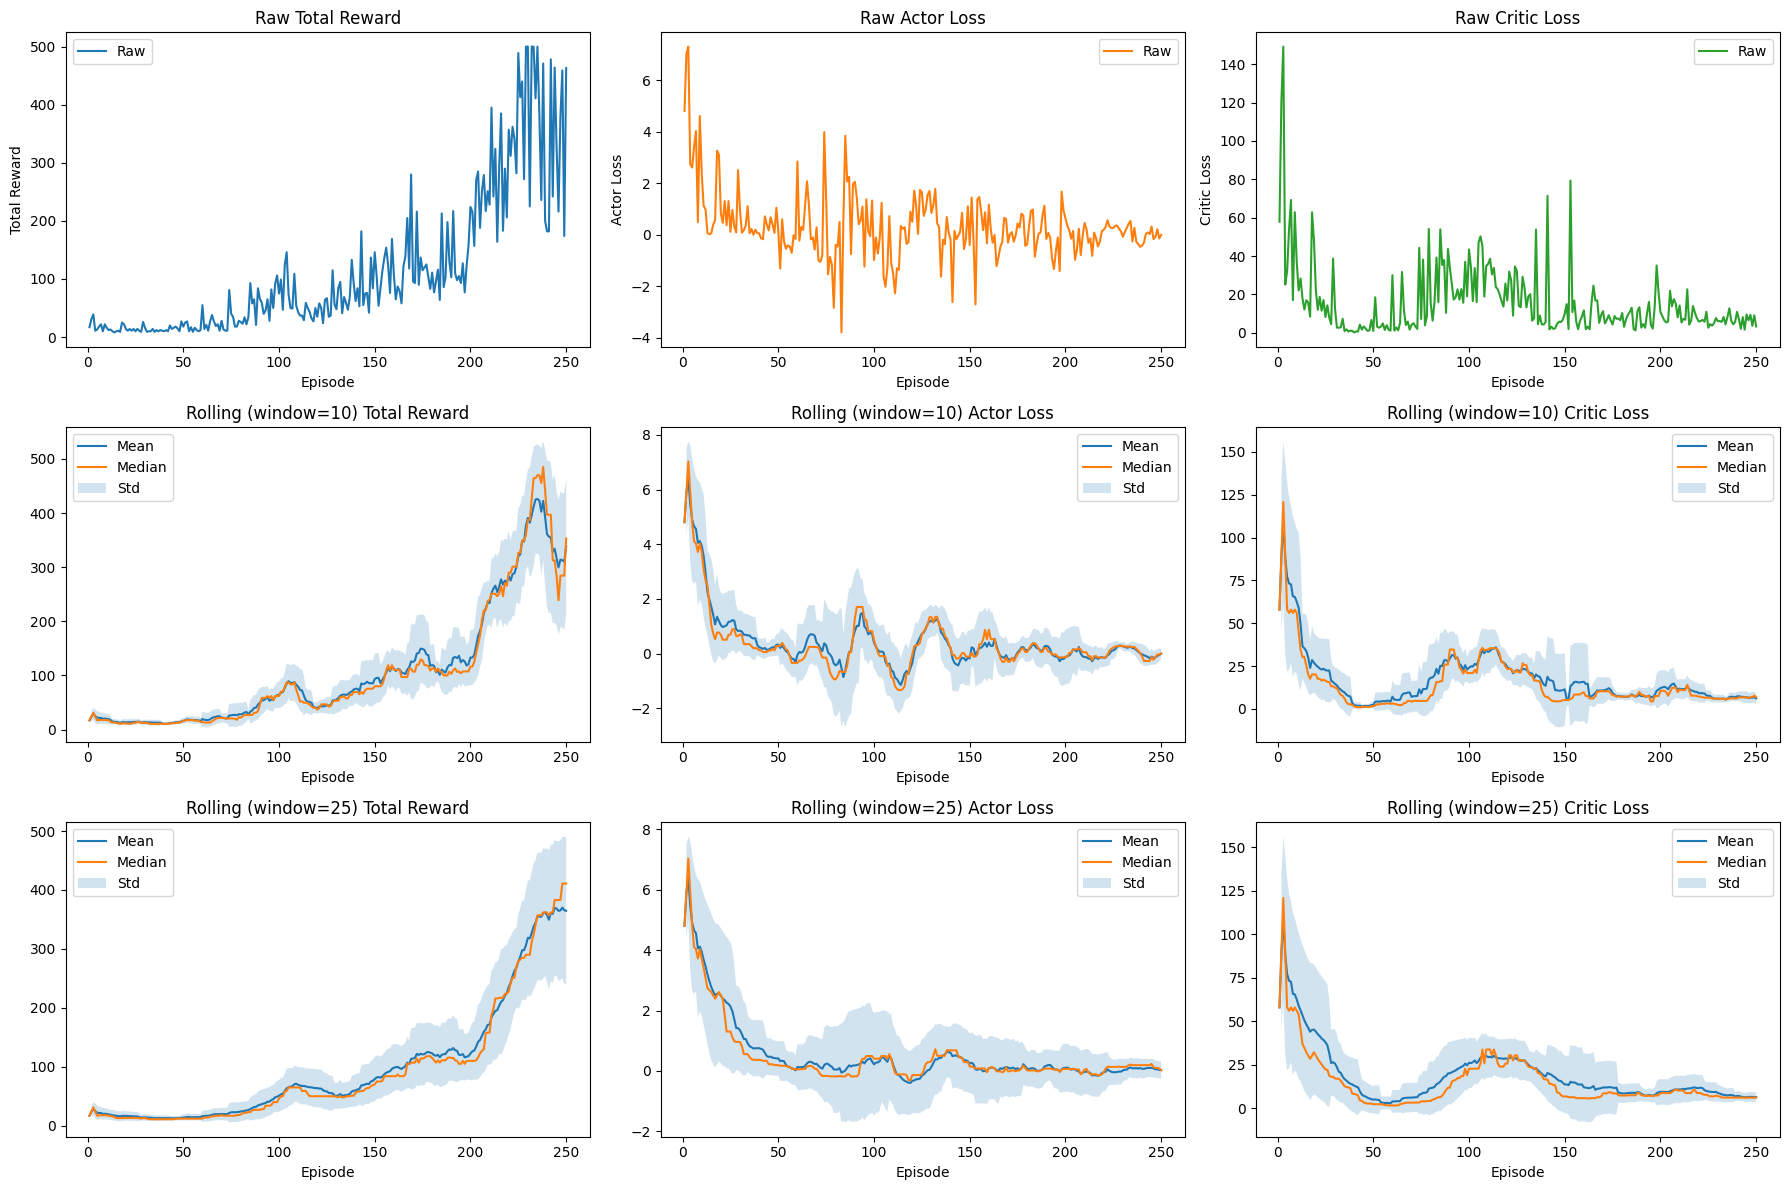

In [ ]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-2,
        "critic_lr": 1e-2,
        "num_episodes": 250,
        "gamma": 0.95,
        "noise_std": 0.01
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)

Episode 10	Total Reward: 14.00	Actor Loss: 2.2497	Critic Loss: 27.5166
Episode 20	Total Reward: 31.00	Actor Loss: 3.7565	Critic Loss: 67.5380
Episode 30	Total Reward: 11.00	Actor Loss: 0.2859	Critic Loss: 6.2377
Episode 40	Total Reward: 18.00	Actor Loss: 0.9263	Critic Loss: 8.4951
Episode 50	Total Reward: 23.00	Actor Loss: 0.9067	Critic Loss: 10.0831
Episode 60	Total Reward: 12.00	Actor Loss: -0.7519	Critic Loss: 3.8298
Episode 70	Total Reward: 19.00	Actor Loss: -0.2397	Critic Loss: 8.5312
Episode 80	Total Reward: 21.00	Actor Loss: -0.9221	Critic Loss: 4.8687
Episode 90	Total Reward: 37.00	Actor Loss: 1.5474	Critic Loss: 17.0296
Episode 100	Total Reward: 20.00	Actor Loss: -0.0421	Critic Loss: 17.8895
Episode 110	Total Reward: 21.00	Actor Loss: -3.4421	Critic Loss: 47.8446
Episode 120	Total Reward: 55.00	Actor Loss: 1.3081	Critic Loss: 27.7839
Episode 130	Total Reward: 75.00	Actor Loss: 0.3478	Critic Loss: 27.8339
Episode 140	Total Reward: 84.00	Actor Loss: 0.7023	Critic Loss: 24.6155
E

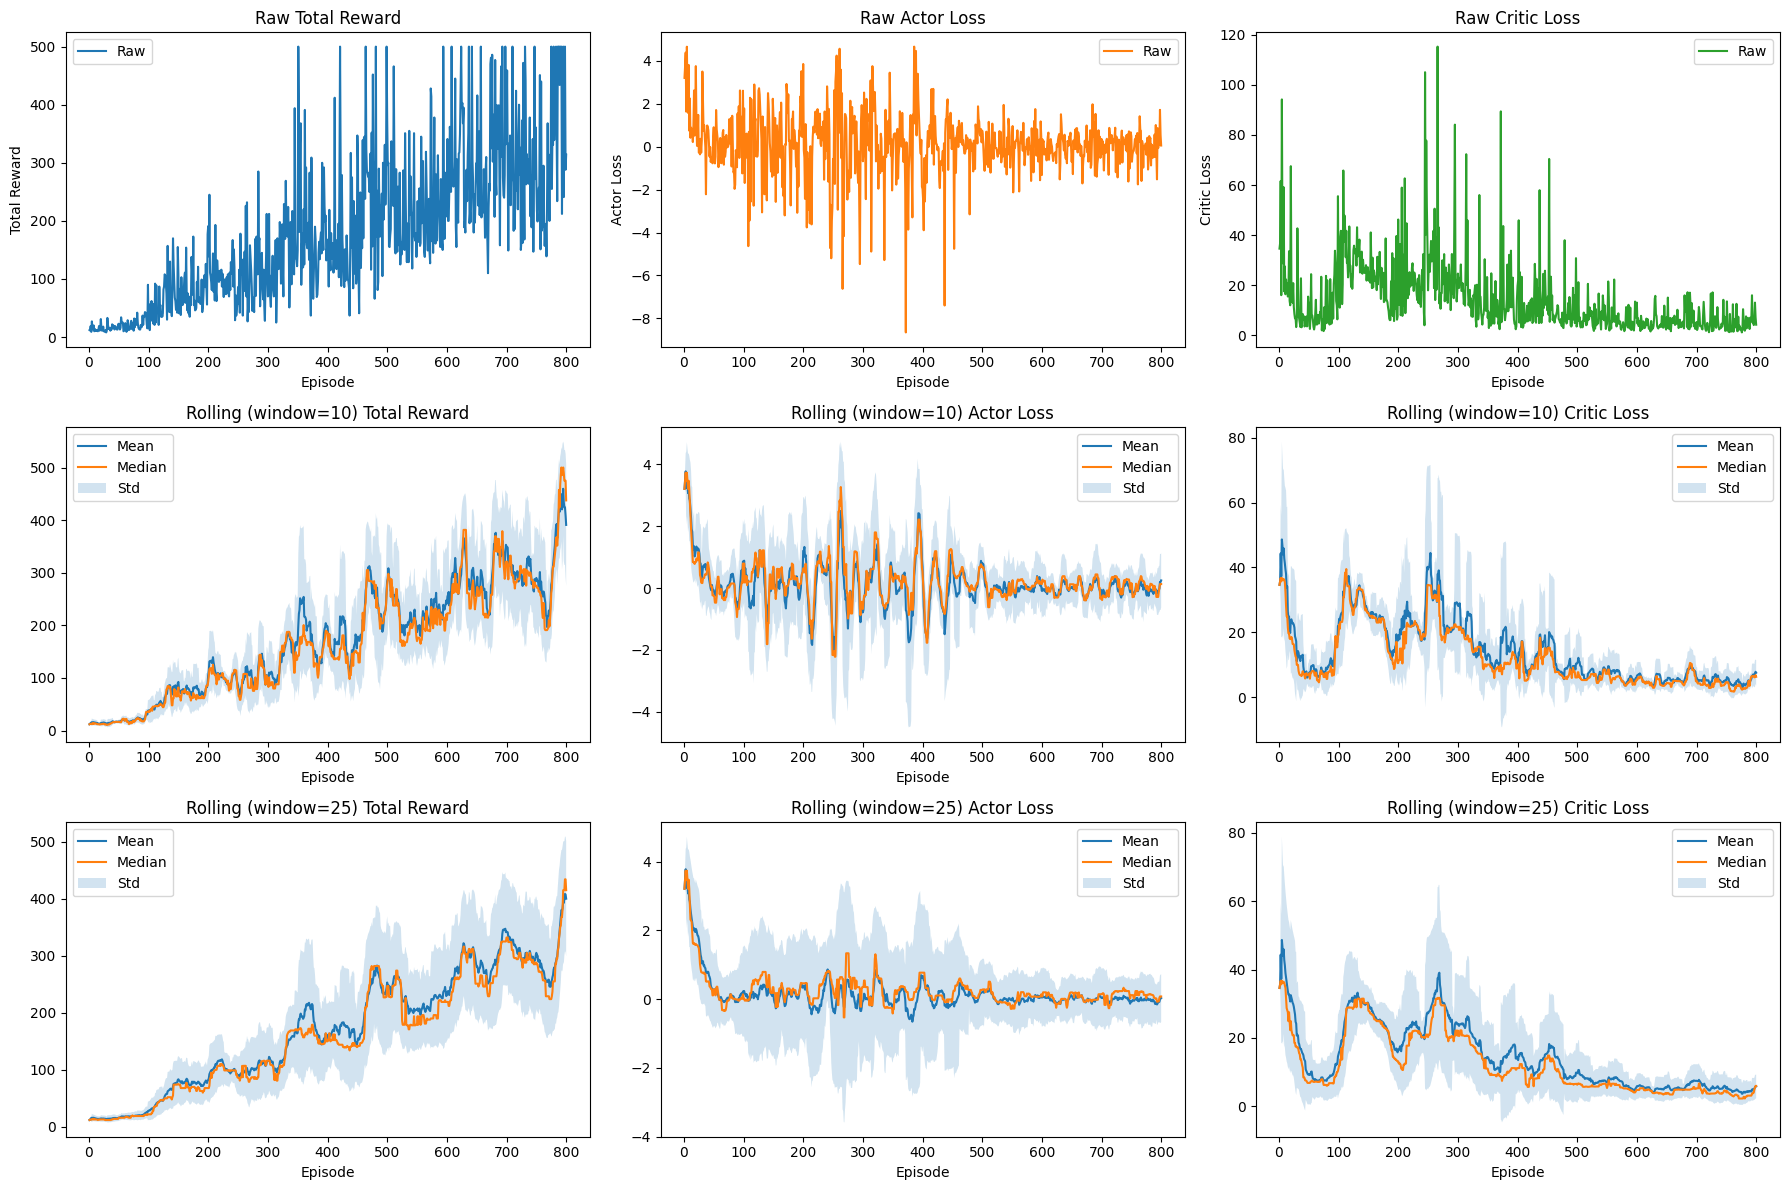

In [4]:
# --------------------------
# Main Function to Run Training
# --------------------------
if __name__ == '__main__':
    env = gym.make("CartPole-v1")
    obs_size = env.observation_space.shape[0]
    act_size = env.action_space.n

    config = {
        "actor_hidden_size": 128,
        "critic_hidden_size": 128,
        "actor_layers": 1,
        "critic_layers": 1,
        "actor_lr": 1e-2,
        "critic_lr": 1e-2,
        "num_episodes": 800,
        "gamma": 0.95,
        "noise_std": 0.2
    }

    agent = ActorCriticAgent(
        obs_size, act_size,
        actor_hidden_size=config["actor_hidden_size"],
        critic_hidden_size=config["critic_hidden_size"],
        actor_layers=config["actor_layers"],
        critic_layers=config["critic_layers"],
        actor_lr=config["actor_lr"],
        critic_lr=config["critic_lr"],
        noise_std=config["noise_std"]
    )

    total_rewards_history, actor_loss_history, critic_loss_history = train_agent(
        env,
        agent,
        num_episodes=config["num_episodes"],
        gamma=config["gamma"]
    )

    plot_metrics(total_rewards_history, actor_loss_history, critic_loss_history, window_1=10, window_2=25)